<a href="https://colab.research.google.com/github/ElenaManari/MLPNS_EManari/blob/main/MCMC_FittingLineToGRBAfterglows_instructions_inclassday2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    
  **TL;DR: we measure a quantity named magnitude over time, which is an inverse logaritmic measure of brightness of the GRB, and which is expected to change it roughly linearly with the logarithm of time.**

_About GRB Afterglows_

*Gamma-ray bursts (GRBs) are bright X-ray and gamma-ray flashes observed in the sky, emitted by distant extragalactic sources. They are associated with the creation or merging of neutron stars or black holes; processes which result in an explosive outburst of material moving incredibly close to the speed of light [ref](https://www.mpg.de/16999277/0607-kern-gammarayburst-153865-x#:~:text=It%20was%20this%20afterglow%20emission,the%20form%20of%20synchrotron%20photons). Long after the initial burst of gamma rays has subsided, gamma ray bursts (GRBs) are still observable at less energetic wavelengths. Although no formal definition exists, this smoothly varying, lower energy radiation that may be visible for several days following the GRB itself, is usually referred to as the GRB afterglow.*


    
  **Details**: *The light that we measure from these explosions changes over time, so we can study its time series. The change in light is exponential, not linear, but if we take the logarithm of the light, that chance may be linear, since the logarithm is the inverse of exponent. The logarithm of the light flux is called magnitude in astronomy. A line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process.*
    
*It is believed that the afterglow originates in the external shock produced as the blast wave from the explosion collides with and sweeps up material in the surrounding interstellar medium. The emission is synchrotron emission produced when electrons are accelerated in the presence of a magnetic field. The successive afterglows at progressively lower wavelengths (X-ray, optical, radio) result naturally as the expanding shock wave sweeps up more and more material causing it to slow down and lose energy.*

*X-ray afterglows have been observed for all GRBs, but only about 50% of GRBs also exhibit afterglows at optical and radio wavelengths [ref](https://astronomy.swin.edu.au/cosmos/G/gamma+ray+burst+afterglow)*

  *In reality, the correct model is a  broken powerlaw: the slope of the line "breaks" or changes, at some point in time. But this exercise is about fitting lines. But in the end we will use MCMC and find out which model is better*

# initial imports

In [73]:
import pandas as pd
import pylab as pl
import numpy as np
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'ndim', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Task 1: Read and prepare the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

find the link to the *raw* input file on github in the HW1 folder https://github.com/fedhere/MLTSA_FBianco/tree/master/HW1

In [74]:
grbAG = pd.read_csv("https://github.com/fedhere/MLPNS_FBianco/raw/main/linearRegression/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [75]:
grbAG.upperlimit.unique()

array([0, 1])

## Create the log-time variable

We will fit a line in log space. The magnitude column I gave you is the logarithm (base 10) of the flus so that is already available. Create a logarithm base 10 of the time variable

(Fitting a line in log-log space corresponds to fitting a powerlaw y=x^a in natural space. Note: we mean logbase 10, use ```numpy.log10()```)

If you have trouble with this look at this gist https://gist.github.com/fedhere/42956d318347def627f6ad750c3eee9a


In [76]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


In [77]:
np.c_?

## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. If I wanted to retrieve all magnitudes for filter 'V' I would do ```grbAG.loc[grbAG["filter"] == f, "mag"]```.

Plot the data with different colors for different photometric bands. 

Use pl.errorbar to display the uncertainties in the data - if you do not know how to use pl.errorbar you can symply type

```pl.errorbar?``` in a cell to retrieve the help

In [78]:
pl.errorbar?

In [79]:
grbAG["filter"].unique()

array(['V', 'M2', 'W1', 'U', 'B', 'W2'], dtype=object)

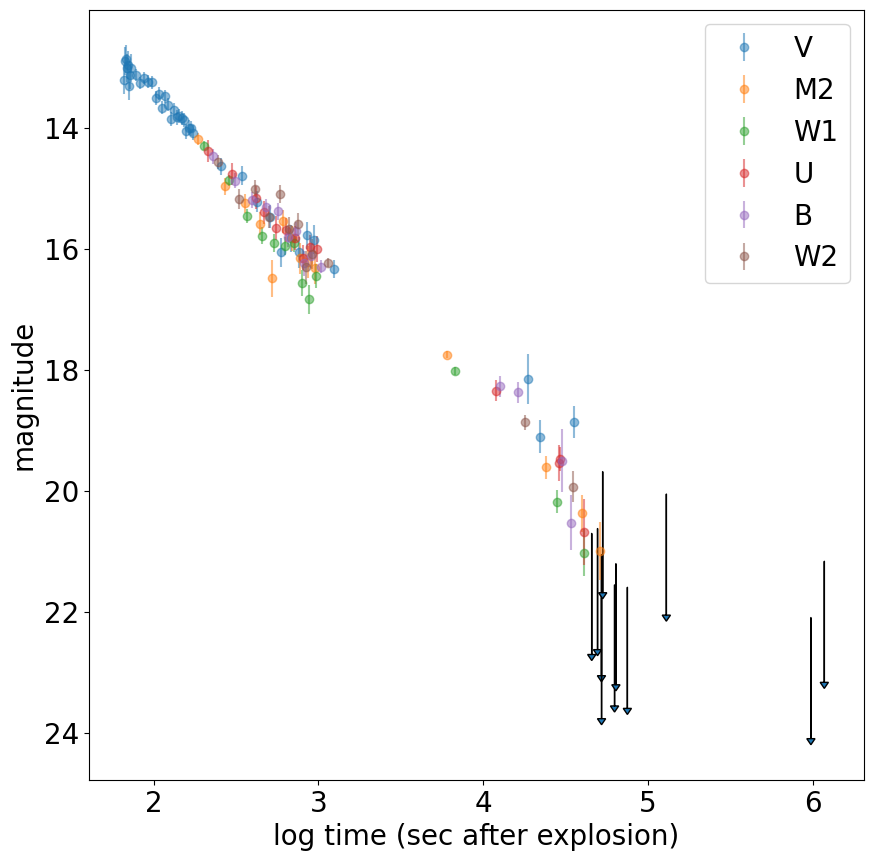

In [80]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f].logtime,   
             grbAG[grbAG["filter"] == f].mag, fmt='o', alpha=0.5,
             yerr=grbAG[grbAG["filter"] == f].magerr, label=f)
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.gca().invert_yaxis()
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);



Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

## Clean the data: Remove upper limits
This data includes upper limits which I plotted as downward errors. upper and lower limits (technically called "censored data" are extremely hard to deal with in modeling). For now, lets just remove them. 

To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```

If you do not know how to remove selected rows from a dataframe based on a condition look at this gist https://gist.github.com/fedhere/e9cd67d9dc0357ee547e03a12ceb4719

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 


# Task 2: Fit models to data
## Task 2a: Solve using the Normal Equation

You can use the code I put in the slides for this - you can copy and paste it but you will learn most if you try type it down and make sure you understand it line by line!!

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [81]:
grbAGnu = grbAG[grbAG.upperlimit == 0] 

In [82]:
np.c_?

In [83]:
np.ones((len(grbAGnu), 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [84]:
x =  grbAGnu.logtime.values # what is your exogenous variable?

X = np.c_[np.ones((len(grbAGnu), 1)),
          x]

y = grbAGnu.mag.values 

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [85]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
                                           
print ("best fit parameters from the Normal Equation: " + 
       "intercept {0:.2f}, slope {1:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Task 2b: Fit a line to the data with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.





In [86]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression

#sklearn is an object oriented package. You will call the function which will create a model (model selection) then fit it to the data separately (model fitting)

lr = LinearRegression()
lr.fit(X,y)
       
#this will create new properties of the model instance: the intercept and coefficients!

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


In [87]:
import scipy as sp
from scipy.optimize import minimize

In [88]:
minimize?

## Optional Task 2c: Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [89]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):
    """"""
    return slope * x + intercept

def l1(args, x, y):
    a, b = args
    return np.sum(np.abs( line(x, a, b) - y)) #see slides!

    


initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whaetever

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.303317772383874
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-1.359e-01 -2.094e+00]
 hess_inv: [[ 1.935e-04 -4.675e-05]
            [-4.675e-05  1.132e-05]]
     nfev: 391
     njev: 125

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [90]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):
    """"""
    return slope * x + intercept

def l2(args, x, y):
    a, b = args
    return np.sum(( line(x, a, b) - y)**2) #see slides!

    


initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whaetever

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072551
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64



## Optional task 2d: Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the Pearson's $\chi^2$ (chi squared) function as your objective function. The $\chi^2$ is the distance between prediction and truth, divided by the uncertainty (sigma squares) see slides or see slides or https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#:~:text=10%20References-,Definition,differs%20from%20a%20theoretical%20distribution.

In [91]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum(((line(x, a, b) - y)**2) /  s**2)
    #see notes

s = grbAGnu.magerr.values 
# assign the uncertainties to s. Its the column names "magerr"

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 317.420669801309
        x: [ 8.599e+00  2.480e+00]
      nit: 4
      jac: [-3.815e-06  0.000e+00]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Task 3: Plot all the solutions

To do this best, you can create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.

If you do not know how to define a function look here. https://gist.github.com/fedhere/babc8d20533acb9288caf097138825bc


In [92]:
ax.plot?

In [93]:
lr.coef_

array([0.        , 2.51199984])

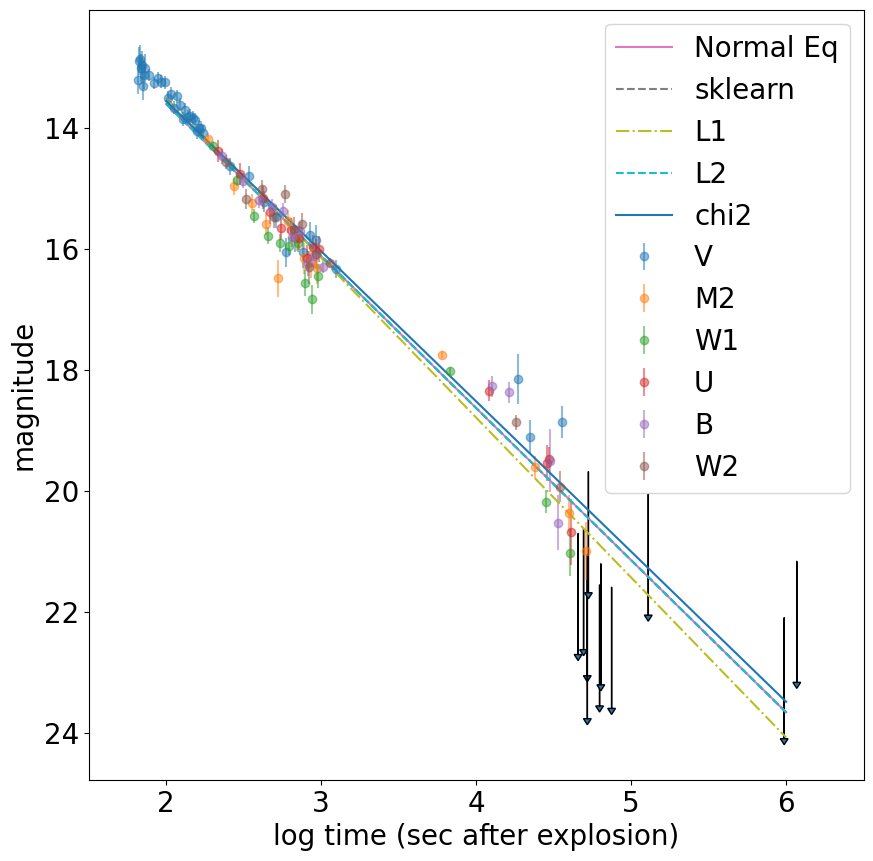

In [94]:
def plotline(x, intercept, slope, legend=None, symbol='-', ax=ax):
    ax.plot(x, line(x, intercept, slope), ls=symbol, label=legend)
    
newx = np.array([2, 6])
ax = pl.figure(figsize=(10,10)).add_subplot(111)


for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f].logtime,   
             grbAG[grbAG["filter"] == f].mag, fmt='o', alpha=0.5,
             yerr=grbAG[grbAG["filter"] == f].magerr, label=f)
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
# plot the datapoints as above as errorbars
# plot the upperlimits as arrows (see above)

#plot the models

#normal equation
plotline(newx, *theta_best, ax=ax, legend="Normal Eq")
         
#sklearn
plotline(newx, lr.intercept_, lr.coef_[1], ax=ax, legend="sklearn", symbol='--')
         
#minimize L1
plotline(newx, *l1Solution.x, ax=ax, legend="L1", symbol='-.')

#minimize L2
plotline(newx, *l2Solution.x, ax=ax, legend="L2", symbol='--')


#minimize chi2
plotline(newx, *chi2Solution.x, ax=ax, legend="chi2", symbol='-')

        
pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.gca().invert_yaxis()

pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# In ML we reserve some data to test our restuls

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x, y, s, test_size=0.25, random_state=42)

In [97]:

chi2Solution = minimize(chi2, initialGuess, args=(x_train, y_train, s_train)) #train on the training set

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 240.77095739586136
        x: [ 8.685e+00  2.450e+00]
      nit: 4
      jac: [-1.907e-06  7.629e-06]
 hess_inv: [[ 1.896e-03 -6.411e-04]
            [-6.411e-04  2.318e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.68, intercept 2.45


In [98]:

l2Solution = minimize(l2, initialGuess, args=(x_train, y_train)) #train on the training set

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 240.77095739586136
        x: [ 8.685e+00  2.450e+00]
      nit: 4
      jac: [-1.907e-06  7.629e-06]
 hess_inv: [[ 1.896e-03 -6.411e-04]
            [-6.411e-04  2.318e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.68, intercept 2.45


In [99]:
# Usiamo L2 come diagnostica del successo del modello
l2(chi2Solution.x, x_test, y_test), l2(l2Solution.x, x_test, y_test)

(2.792722002650649, 2.4758681643203264)

# now fit a line with MCMC


In [100]:
!pip install emcee  # pip comando di unix, metto ! perchè non è di python, system command --> !

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
import emcee

In [102]:
! pip install corner  # per marginalized probability plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
# P(a,b|y)=P(y|a,b)P(a,b)

In [104]:
# Definisco la posterior probability

In [105]:
def log_prior(theta): 
#theta touple
  slope, intercept = theta
  if slope > 0 and intercept > 0 :   # sema informative prior
    return 0 # più grande di meno infinito, la posterior interamente dominata dalla liklihood
  return -np.inf

In [106]:
#def log_prior(theta):
"""  semi informative prior: 
i know light has to get fainter (mag get bigger)
i know i dont use negative mags
theta: array-like, slope and intercept"""

    #return 0 #if within prior return 0

 # return -np.inf

'  semi informative prior: \ni know light has to get fainter (mag get bigger)\ni know i dont use negative mags\ntheta: array-like, slope and intercept'

In [107]:
def log_likelihood(theta, x, y, yerr):
  """ this is where the model goes: the likelihood can be a simple gaussian likelihood 
  (i.e.) the log likelihood is the chi squared!
  theta: array-like, slope and intercept
  x arra-like: exogenous variable
  y arra-like: endogenous variable
  yerr arra-like: uncertainty on endogenous variable"""
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)   # ritorno il - chi2... infatti è log(e^-chi2)

In [108]:
def log_probability(theta, x, y, yerr):  #log posterior, log probability, chiama le funzioni che ho fatto
  """ the posterior probability
  P(model | data) ~ P(data | model) * P(model) = likelihood * prior

  theta: array-like, slope and intercept
  x arra-like: exogenous variable
  y arra-like: endogenous variable
  yerr arra-like: uncertainty on endogenous variable"""

  #check the prior
  lp=log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp+log_likelihood(theta, x, y, yerr)

In [109]:
ig = [10,1] #initial guess
ndim = len(ig) #the dimension of the parameter space
nwalkers = 32 #number of walkers (independent optimization paths), catene che vanno in parallelo, proporzionale 
              # alle risorse computazionali e al numero di parametri, hyperparameter, decisa dall'analista non 
              # dai dati
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) # the starting position for each walker, close to the initial guess
# introduco un po' di noise, stocasticità.. gaussian draw per ogni walkers, ndim 

pos.shape

(32, 2)

In [110]:
# Codice per settare la Markov chain e per inizializzarla
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, s)) #create the emcee object
sampler.run_mcmc(pos, 20000, progress=True);       #run the emcee for 5000 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=200, thin=15, flat=True) #throw away burn in phase

mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84]) #extract the interquartile range and median solution for each parameter
mcmc

100%|██████████| 20000/20000 [00:34<00:00, 581.15it/s]


array([[8.56094147, 8.59983557, 8.63914022],
       [2.46581788, 2.48007123, 2.49408576]])

In [111]:
!pip install corner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


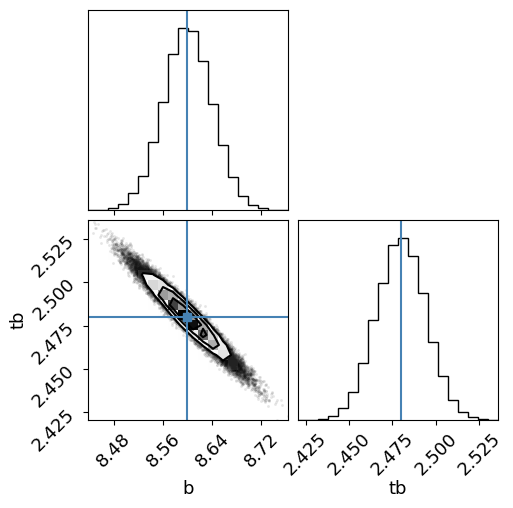

In [112]:
# plot the posterior
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(flat_samples, labels=pars, truths=mcmc[:,1]);


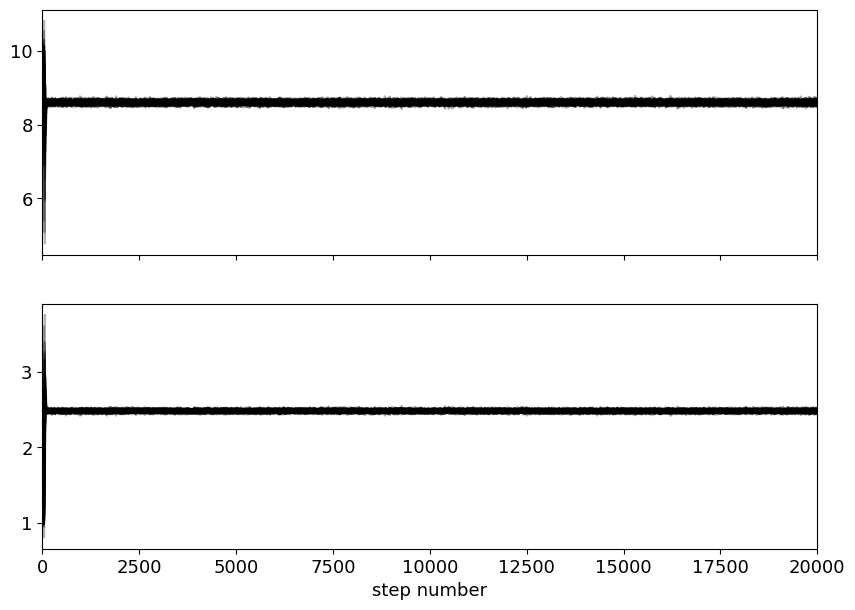

In [113]:
# plot the chais
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# now try a broken power law with MCMC

New model: 

$F = \mathrm{flux}$

$t =  \mathrm{time}$

$T_b =  \mathrm{Time~of~break}$

$a_1, a_2, T_b, b:  \mathrm{model parameters}$


$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [114]:
pars = ['b', 'Tb', 'a1', 'a2']
def bpl(theta, t):
  b, tb, a1, a2 = theta
  return b - np.log10(np.power(t / tb, -a1) + np.power(t / tb, -a2))
  


In [115]:
x_nolog = grbAGnu.time.values

In [125]:
def log_prior(theta):
  b, Tb, a1, a2 = theta
  if Tb >0 and a1 >0 and a2 > 0 and Tb < 10**6:
    return 0
  return -np.inf

In [126]:
def log_likelihood(theta, x, y, yerr):
  return -np.sum(((y-bpl(theta,x))**2/yerr**2))
  

In [127]:
nll = lambda *args: -log_likelihood(*args)
ig = [12, 2000, 2.5, 2.5]

soln = minimize(nll, ig, args=(x_nolog, y, s))
soln

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 217.4653145711489
        x: [ 1.505e+01  2.736e+02  2.146e+00  3.548e+00]
      nit: 89
      jac: [-3.376e-04  5.722e-06 -8.392e-05 -6.866e-05]
 hess_inv: [[ 2.412e-04  1.075e-04 -1.904e-04  7.557e-04]
            [ 1.075e-04  3.723e-04  2.052e-05  1.064e-03]
            [-1.904e-04  2.052e-05  3.472e-04 -6.220e-04]
            [ 7.557e-04  1.064e-03 -6.220e-04  4.964e-03]]
     nfev: 852
     njev: 168

In [146]:
#initial guess
ig = soln.x
nwalkers = 50
ndim = len(ig)

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

pos.shape

(50, 4)

In [147]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_nolog, y, s))
sampler.run_mcmc(pos, 20000, progress=True);
samples = sampler.get_chain()

flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

100%|██████████| 20000/20000 [00:53<00:00, 372.51it/s]


array([[ 14.86961518,  15.09306277,  15.33741919],
       [236.60968636, 284.19115665, 348.94860648],
       [  2.09820644,   2.13939243,   2.17690346],
       [  3.40793226,   3.52314539,   3.64608853]])

In [148]:
pars

['b', 'tb', 'a1', 'a2']

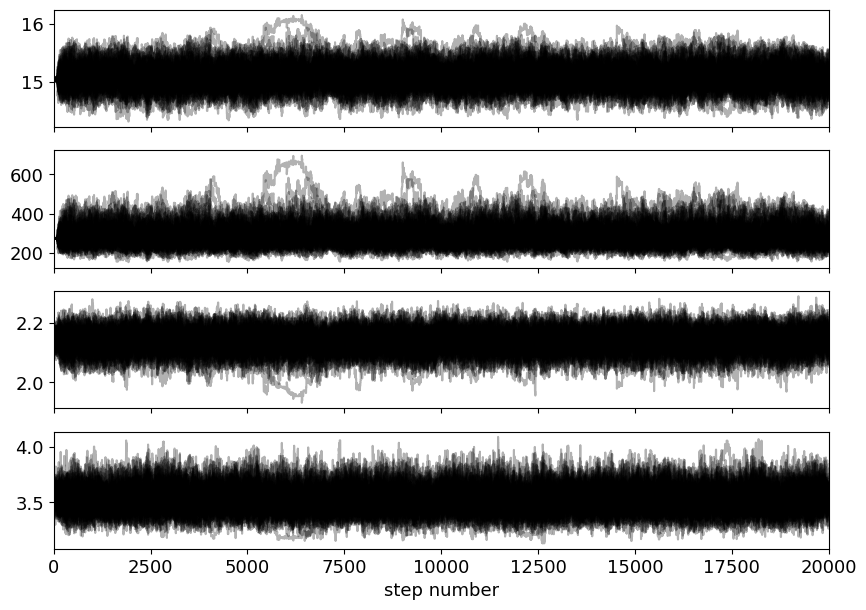

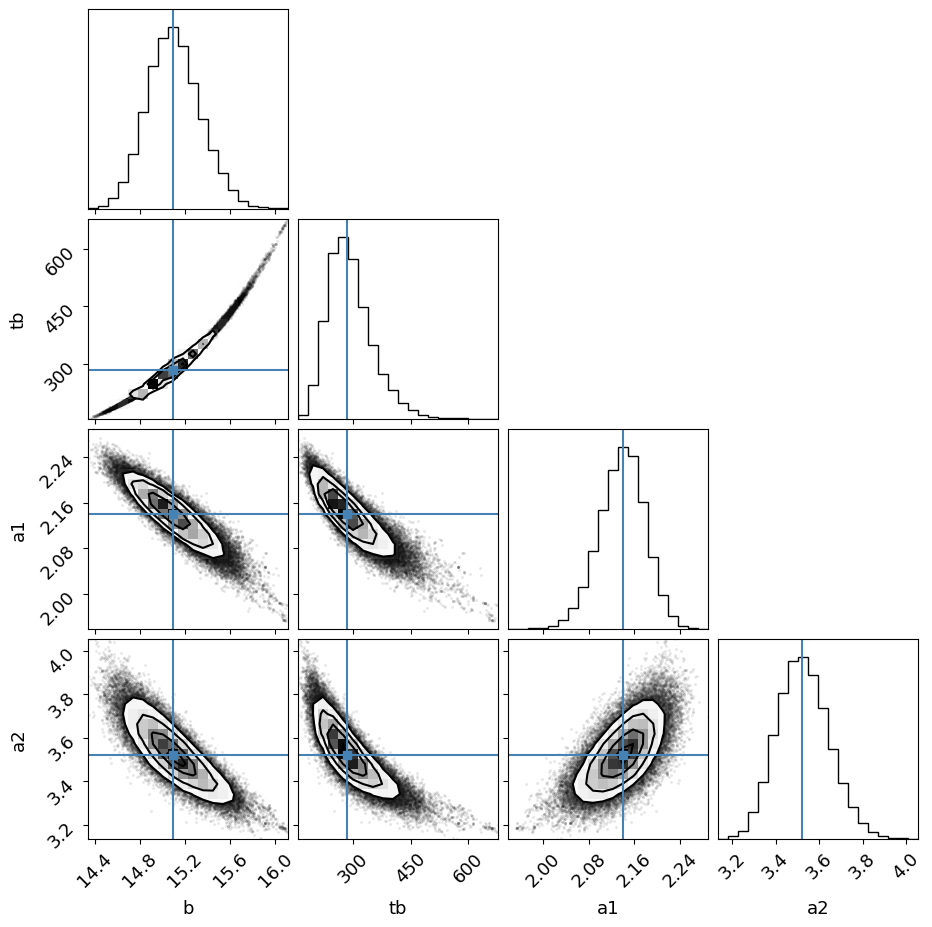

In [149]:
bfig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(flat_samples, labels=pars, truths=mcmc[:,1]);


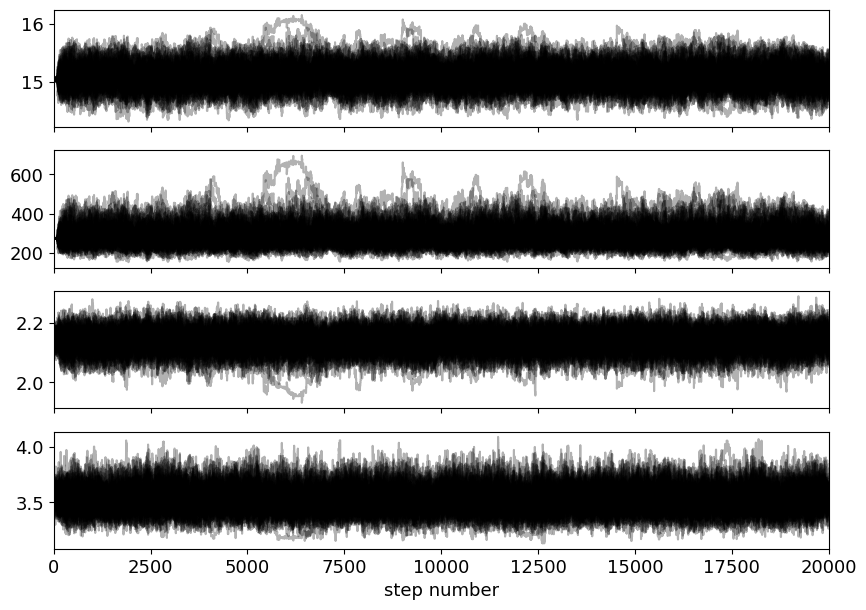

In [150]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

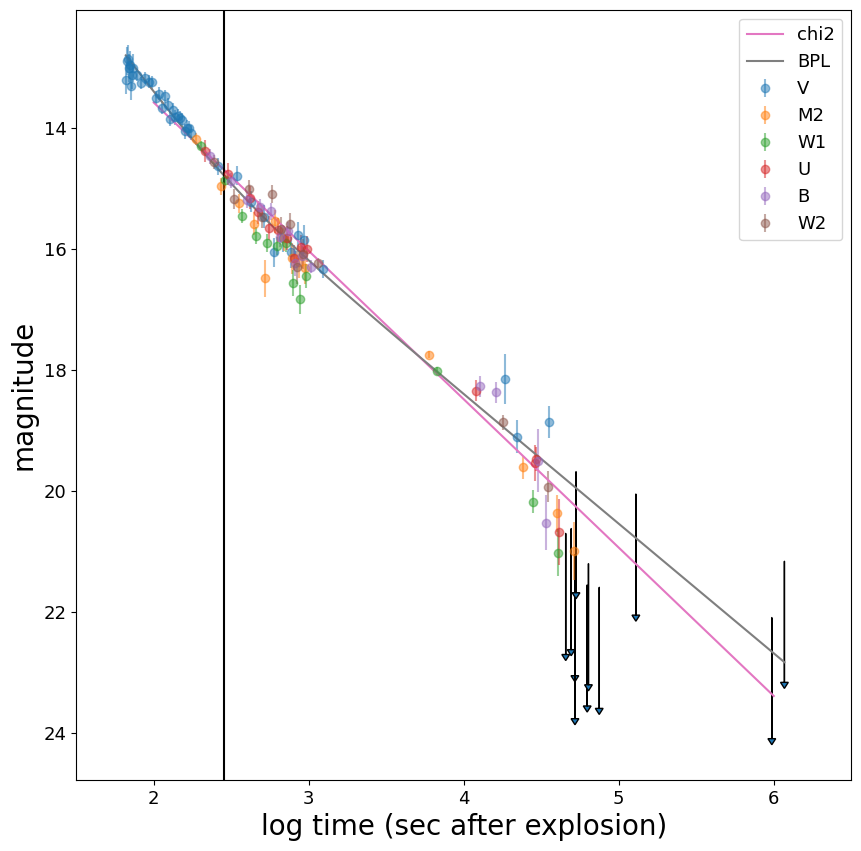

In [151]:
def plotline(x, intercept, slope, legend=None, symbol='-', ax=ax):
    ax.plot(x, line(x, intercept, slope), ls=symbol, label=legend)


newx = np.array([2, 6])
ax = pl.figure(figsize=(10,10)).add_subplot(111)


for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f].logtime,   
             grbAG[grbAG["filter"] == f].mag, fmt='o', alpha=0.5,
             yerr=grbAG[grbAG["filter"] == f].magerr, label=f)
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
# plot the datapoints as above as errorbars
# plot the upperlimits as arrows (see above)

#plot the models


#minimize chi2
plotline(newx, *chi2Solution.x, ax=ax, legend="chi2", symbol='-')
newx2 = np.linspace(grbAG.logtime.min(), grbAG.logtime.max(), 100)
ax.plot(newx2, bpl(mcmc[:,1], 10**newx2), label="BPL")
ax.axvline(np.log10(mcmc[1,1]), color='k')
pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.gca().invert_yaxis()

pl.xlabel("log time (sec after explosion)", fontsize=20);

In [153]:
# Comparazione dei due modelli con il metodo LR
-2*log(-np.sum(((y - line(8.59983557, 2.48007123, x))**2) / yerr**2)/-np.sum(((y-bpl(theta,x))**2/yerr**2)))

NameError: ignored